# Pipeline

In [ ]:
## Project on Healpix sphere

In [1]:
# 1  Healpix reproject

from wfiskymatch.skymatch import fits2healpix
import tarfile, os, gzip
with tarfile.open('/Users/dfadda/Roman/BgrMatch/2MASS/M31/images.tar') as tar:
    for item in tar.getnames():
        if item.endswith('fits.gz'):
            print('.',end='')
            tar.extract(item, '.',filter='data', numeric_owner=True)
            fits2healpix(item, '/Users/dfadda/Roman/output')
            os.remove(item) 

...................................................................................................................................................................................................................................................................................................................................................................

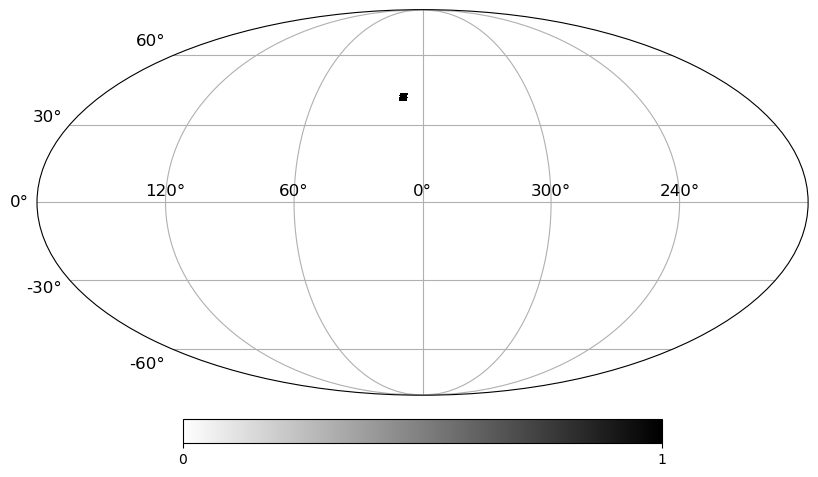

In [1]:
# check: show the coverage
from wfiskymatch.skymatch import plotcoverage
from glob import glob as gb
files = sorted(gb('/Users/dfadda/Roman/output/*h5'))
plotcoverage(files)

In [1]:
# 2 Compute the offsets
from wfiskymatch.skymatch import computeOffsets
from glob import glob as gb
files = sorted(gb('/Users/dfadda/Roman/output/*.h5'))
offsets = computeOffsets(files, outfile='/Users/dfadda/Roman/offsets')

There is a total of 2644 overlaps
..................................................................................................................................................................................................................................................................................................................................................................

aJ_asky_001016n0910173


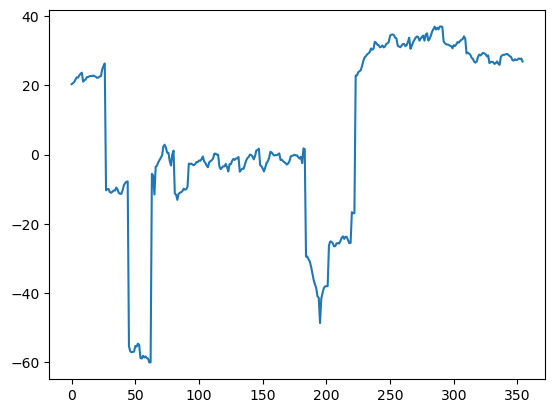

In [2]:
# check: plot the offsets
import matplotlib.pyplot as plt
import h5py
with h5py.File('/Users/dfadda/Roman/offsets.h5', 'r') as hdf5_file:
    offsets = hdf5_file['offsets'][:]
    files = hdf5_file['files'][:]    

print(files[0].decode('UTF-8'))
plt.plot(offsets);

In [4]:
# 3 Coaddition using the offsets
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
from astropy.io import fits
import tarfile, os, gzip
import h5py
from astropy.wcs import WCS

with h5py.File('/Users/dfadda/Roman/offsets.h5', 'r') as hdf5_file:
    offsets = hdf5_file['offsets'][:]
    files = hdf5_file['files'][:] 

print('Reading files ...')
elist=[]
i=0
with tarfile.open('/Users/dfadda/Roman/BgrMatch/2MASS/M31/images.tar') as tar:
    for file, offset in zip(files,offsets):
        print('.',end='')
        item = file.decode('UTF-8')+'.fits.gz'
        tar.extract(item, '.',filter='data', numeric_owner=True)
        with fits.open(item) as hdu:
            header = hdu[0].header
            array = hdu[0].data + offset
            wcs = WCS(header)
            elist.append((array,wcs))
        os.remove(item) 

print('\nReprojecting ...')
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp

# Extent of the coaddition
wcs_out, shape_out = find_optimal_celestial_wcs(elist)

earray, footprint = reproject_and_coadd(elist,
                                       wcs_out, shape_out=shape_out,
                                       reproject_function=reproject_interp)
# Save the result
print('Saving the result')
fits.writeto('/Users/dfadda/Roman/M31_wfiskymatch.fits', earray, wcs_out.to_header(), overwrite=True)

Reading files ...
...................................................................................................................................................................................................................................................................................................................................................................
Reprojecting ...
Saving the result


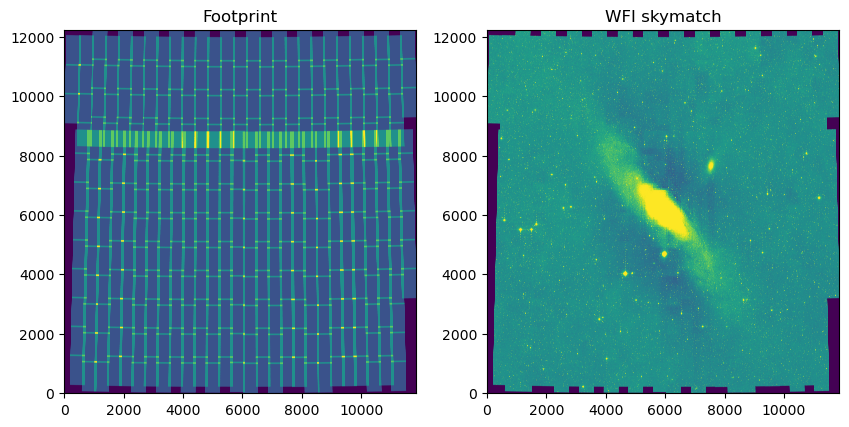

In [5]:
# check: show the result
import numpy as np
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10,6))
im0 = axs[0].imshow(footprint, origin='lower')
axs[0].set_title('Footprint')
d = 5
im2 = axs[1].imshow(earray-np.nanmedian(earray), origin='lower',  vmin=-d, vmax=d)
axs[1].set_title('WFI skymatch')
plt.show()
